# Functional network construction and cell ranking for in-vitro neuronal populations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff

### Manual input parameters

In [2]:
expected_neuron_radius_pix = 5
dff_baseline_size = 300
dff_baseline_percent = 75
min_pk_height = 0.2

### Load image stack 


In [3]:
path = '../data/DFFtest.tif'
img = tiff.imread(path) # array of images: use [index] to access a specific slide
img_array = np.array(img) # np array of coordinates/values
# 1st dimension: image, 2nd dimension: row of image, 3rd dimension: col of image
img_array = img_array / 255
# print(img_array[0])

[[0.00392157 0.00392157 0.00784314 ... 0.00392157 0.00392157 0.00392157]
 [0.00392157 0.00784314 0.00392157 ... 0.00392157 0.00392157 0.        ]
 [0.00784314 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]
 ...
 [0.0745098  0.07058824 0.07058824 ... 0.01176471 0.00784314 0.01176471]
 [0.06666667 0.07058824 0.07058824 ... 0.01176471 0.00392157 0.01176471]
 [0.06666667 0.07058824 0.07843137 ... 0.00784314 0.00784314 0.00784314]]


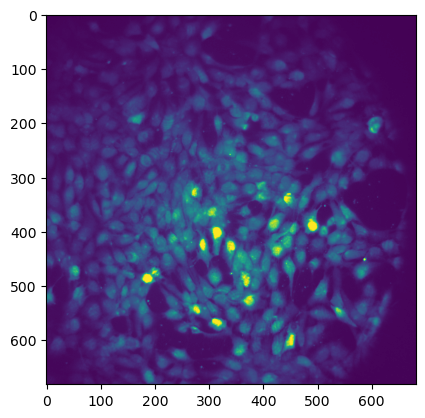

In [4]:
plt.imshow(img[420]) # 420th img in the tif

In [9]:
mean_img = (np.mean(img_array, axis = 0))
# print(mean_img[0, : 5])


Note: it is too computationally expensive to calculate the entire 682 x 682 standard deviation matrix at once (i.e. kernel crashes), so I calculated two sub-arrays and concatenated them in std_img for the full matrix

In [4]:
test1 = img_array[:, :, :341]
std1 = (np.std(test1, axis = 0))
# print(std1)
# print(std1.shape)

[[0.00195072 0.00201448 0.00194626 ... 0.00222833 0.00225446 0.00221204]
 [0.00202546 0.00185687 0.00200407 ... 0.00242143 0.00218731 0.00246903]
 [0.00199825 0.00196873 0.00194876 ... 0.0023103  0.00220206 0.00225735]
 ...
 [0.01412738 0.01398531 0.01414049 ... 0.0089537  0.00844963 0.00791244]
 [0.01312977 0.01377575 0.01463246 ... 0.00927877 0.00963372 0.00926453]
 [0.01287779 0.01327399 0.01441845 ... 0.01143014 0.0125168  0.01266609]]
(682, 341)


In [5]:
test2 = img_array[:, :, 341:]
std2 = (np.std(test2, axis = 0))
# print(std2)
# print(std2.shape)

[[0.00221353 0.00220786 0.00224094 ... 0.00193739 0.00167722 0.00173958]
 [0.00221982 0.00248131 0.00229726 ... 0.00178489 0.00108878 0.00182474]
 [0.00240818 0.00243526 0.0024628  ... 0.00185501 0.00163499 0.00135152]
 ...
 [0.00781721 0.00772464 0.00740639 ... 0.00260718 0.00223838 0.00217912]
 [0.00909966 0.00881241 0.00897782 ... 0.00236077 0.00215209 0.00195355]
 [0.01215332 0.0119359  0.01127502 ... 0.00178801 0.0033491  0.00214923]]
(682, 341)


In [6]:
std_img = np.concatenate((std1, std2), axis=1)
 #print(std_img.shape)

(682, 682)


### Measure variance of image

In [23]:
cv_img = std_img / mean_img # coefficient of variation or relative standard deviation
v2_mean_img = (std_img * std_img) / mean_img # variance to mean ratio
recip_img = mean_img / std_img # reciprocal ratio (SNR)
recip_sqimg = (mean_img / std_img) ** 2 # ^^ squared
eff_img = cv_img ** 2 # efficiency

(682, 682)


/var/folders/_c/3ryrb96d5p152b08284fyjvm0000gn/T/ipykernel_61435/3669960295.py:3: RuntimeWarning: divide by zero encountered in true_divide
  recip_img = mean_img / std_img # reciprocal ratio (SNR)
/var/folders/_c/3ryrb96d5p152b08284fyjvm0000gn/T/ipykernel_61435/3669960295.py:4: RuntimeWarning: divide by zero encountered in true_divide
  recip_sqimg = (mean_img / std_img) ** 2 # ^^ squared


Plots

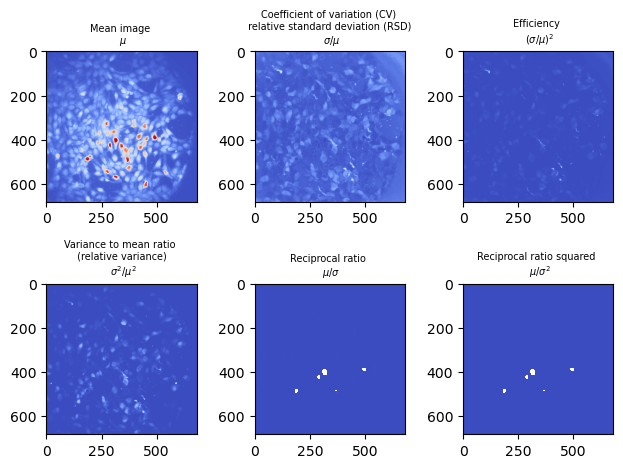

In [86]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
fig.tight_layout()

ax1.set_title("Mean image \n $\mu$", fontsize=7)
ax1.imshow(mean_img, cmap='coolwarm')

ax2.set_title("Coefficient of variation (CV) \n relative standard deviation (RSD) \n $\sigma / \mu$", fontsize=7)
ax2.imshow(cv_img, cmap='coolwarm')

ax3.set_title("Efficiency \n $(\sigma / \mu)^2$", fontsize=7)
ax3.imshow(eff_img, cmap='coolwarm')

ax4.set_title("Variance to mean ratio \n (relative variance) \n $\sigma^2 / \mu^2$", fontsize=7)
ax4.imshow(v2_mean_img, cmap='coolwarm')

ax5.set_title("Reciprocal ratio \n $\mu / \sigma$", fontsize=7)
ax5.imshow(recip_img, cmap='coolwarm')

ax6.set_title("Reciprocal ratio squared \n $\mu / \sigma^2$", fontsize=7)
ax6.imshow(recip_sqimg, cmap='coolwarm')

### Identify cell centers

Manual

Load

Automatic (difference of gaussian)

### Extract fluorescence over time from a circle around selected cell coordinates

FUNCTION: fluoro extraction (assume all ROI are the same)

### dF/F calculation

FUNCTION: sliding window dF/F calculation

### Look for peaks (test)

### Correlation coefficient (test)

### Cross correlation (test)

### Distance matrix

### Plot dF/F and correlation matrix

### Get triangles

### Plot distance v correlation scatters

FUNCTION: binned mean

FUNCTION: scatter kernel density estimate

kernel density estimate

desu density scattercloud

### Histogram of correlation coefficient